In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy
from arch import arch_model
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Choose Google as our target company
ticker = "GOOG" 
print("Stock: ", ticker)
# Choose end date as 2024/06/01 and the previous three years of data as our date range. 
end_date = datetime(2024,6,1).strftime("%Y-%m-%d")
start_date = (datetime(2024,6,1)-relativedelta(years=3)).strftime("%Y-%m-%d")
print("Dates: {} to {}".format(start_date, end_date))

Stock:  GOOG
Dates: 2021-06-01 to 2024-06-01


In [5]:
yf_stock = yf.Ticker(ticker) 
df = yf.download(ticker, start=start_date, end=end_date)
df['pct_change'] = df['Adj Close'].pct_change()
df.reset_index(inplace=True)
df['log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
print(df.head())

[*********************100%***********************]  1 of 1 completed

        Date        Open        High         Low       Close   Adj Close  \
0 2021-06-01  121.099998  121.898552  120.244003  121.490501  121.192879   
1 2021-06-02  121.765503  122.099998  120.209999  121.064003  120.767418   
2 2021-06-03  119.750999  120.487251  119.141502  120.230499  119.935959   
3 2021-06-04  121.125999  122.692947  120.888496  122.587997  122.287682   
4 2021-06-07  122.566002  123.400002  122.053650  123.304497  123.002426   

     Volume  pct_change  log_return  
0  19166000         NaN         NaN  
1  17158000   -0.003511   -0.003517  
2  18346000   -0.006885   -0.006909  
3  25948000    0.019608    0.019418  
4  23850000    0.005845    0.005828  


In [6]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    This function is used to calculate the Black-Scholes option price.

    S: current stock price
    K: option strike price
    T: time to expiration in years
    r: risk-free interest rate
    sigma: volatility of the underlying asset
    option_type:'call' or 'put'
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")


def vega(S, K, T, r, sigma):
    """
    This function is used to calculate the vega of the option.
    Same parameters explanation as above
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def implied_volatility(S, K, T, r, market_price, option_type='call', initial_guess=3, tolerance=1e-10, max_iterations=500):
    """
    This function is used to calculate implied volatility for a call or put option using the Newton-Raphson method.

    Same parameters explanation as above
    market price: market price of the option
    initial guess: initial guess is set to 3 as default as it is close to the historical average implied volatility for many options
    tolerance: stop point of the iteration
    max_iteration: maximum iteration allowed for the method
    """
    sigma = initial_guess
    for _ in range(max_iterations):
        p_diff = black_scholes_price(S, K, T, r, sigma, option_type) - market_price
        Vega = vega(S, K, T, r, sigma)
        sigma_new =  sigma - p_diff / Vega
        c_new = black_scholes_price(S, K, T, r, sigma_new, option_type)
        if (abs(sigma - sigma_new) < tolerance or abs(c_new - market_price) < tolerance):
            break
        sigma = sigma_new 
    return sigma  # Return the estimated implied volatility

In [7]:
def implied_volatility_BM(S, K, T, r, market_price, option_type='call', low_guess=0.05, high_guess=3, tolerance=1e-6, max_iterations=500):
    """
    This function is used to calculate implied volatility for a call or put option using the Bisection method.

    Same parameters explanation as above
    market price: market price of the option
    initial guess: initial guess is set to 3 as default as it is close to the historical average implied volatility for many options
    tolerance: stop point of the iteration
    max_iteration: maximum iteration allowed for the method
    """
    for _ in range(max_iterations):
        ch = black_scholes_price(S, K, T, r, high_guess, option_type)
        cl = black_scholes_price(S, K, T, r, low_guess, option_type)
        sigma_new = low_guess + (market_price - low_guess)*(high_guess - low_guess)/(ch-cl)
        c_new = black_scholes_price(S, K, T, r, sigma_new, option_type)
        if c_new < market_price:
            low_guess = sigma_new
        else:
            high_guess = sigma_new
        if (abs(high_guess - low_guess) < tolerance or abs(c_new - market_price) < tolerance):
            break
    return sigma_new

In [8]:
print("option dates: ", yf_stock.options)
# Use the earliest option maturity
option_date = yf_stock.options[0]
nyse = mcal.get_calendar('NYSE')
r = 0.04 # Set contant risk-free rate at 4%
S = df['Adj Close'].values[-1]
T = len(nyse.valid_days(start_date=end_date, end_date=option_date))/252

option dates:  ('2024-10-18', '2024-10-25', '2024-11-01', '2024-11-08', '2024-11-15', '2024-11-22', '2024-12-20', '2025-01-17', '2025-02-21', '2025-03-21', '2025-05-16', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-12-18', '2027-01-15')


In [9]:
call, put = yf_stock.option_chain(option_date)[0], yf_stock.option_chain(option_date)[1]
call = call[call['inTheMoney'] == False]
put = put[put['inTheMoney'] == False]
option_info = call.merge(put, left_on='strike', right_on='strike', suffixes=('_call', '_put'), how='outer')
option_info.sort_values('strike', inplace=True)
option_info = option_info[['strike','inTheMoney_call','lastPrice_call', 'impliedVolatility_call', 'inTheMoney_put','lastPrice_put', 'impliedVolatility_put']]
option_info['impliedVolatility'] = option_info.apply(lambda x: implied_volatility(S, x['strike'], T, r, x['lastPrice_call']) if x['inTheMoney_call'] == False
 else implied_volatility(S, x['strike'], T, r, x['lastPrice_put'], option_type='put'), axis = 1)
option_info['impliedVolatility_yh'] = option_info.apply(lambda x: x['impliedVolatility_call'] if x['inTheMoney_call'] == False
 else x['impliedVolatility_put'], axis=1)
option_info = option_info[['strike', 'impliedVolatility','impliedVolatility_yh']]
option_info.set_index('strike', inplace=True)

option dates:  ('2024-10-18', '2024-10-25', '2024-11-01', '2024-11-08', '2024-11-15', '2024-11-22', '2024-12-20', '2025-01-17', '2025-02-21', '2025-03-21', '2025-05-16', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-12-18', '2027-01-15')


Text(0.5, 1.0, 'Term Structure')

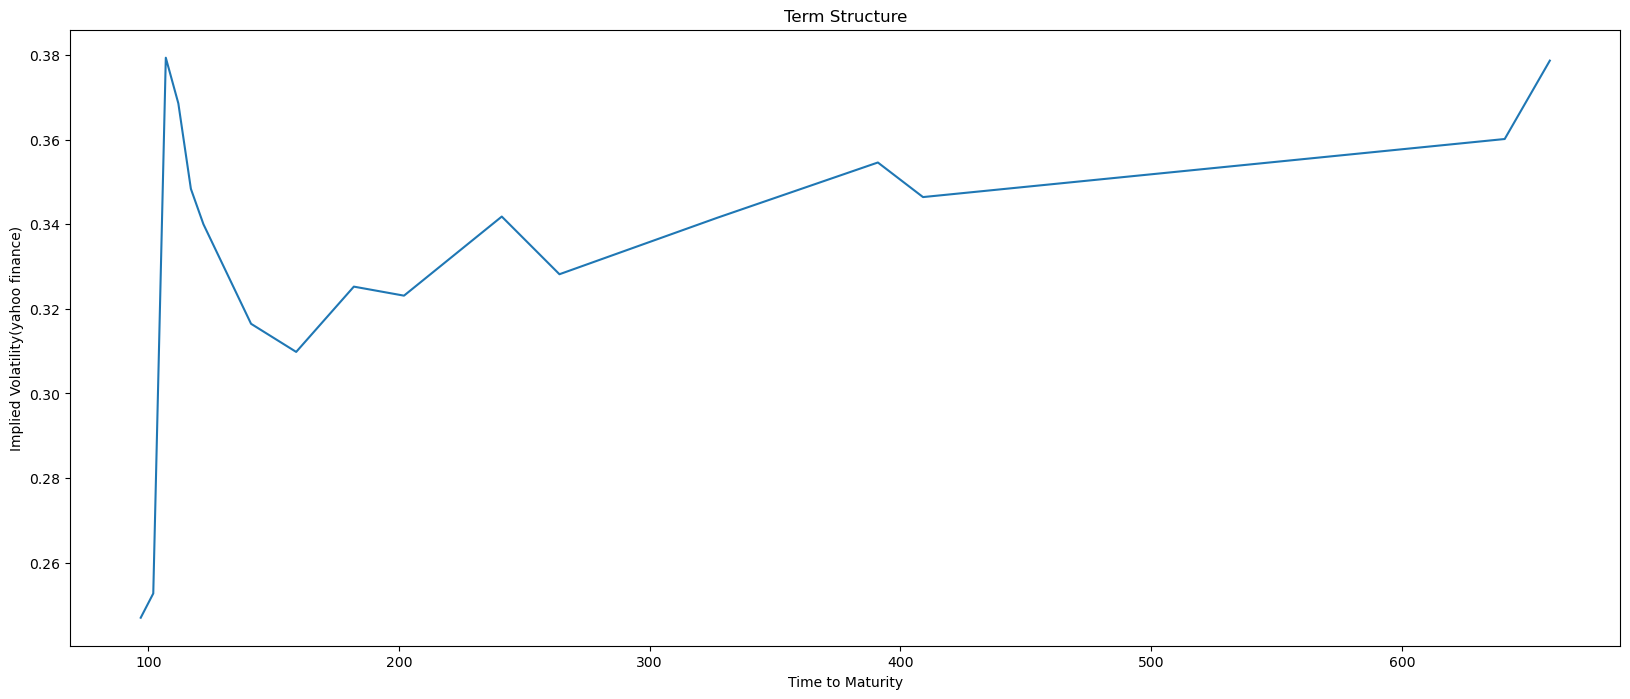

In [10]:
print('option dates: ', yf_stock.options) 
K = 165
 
Ivol = []
Maturity = []
for date in yf_stock.options: 
    call = yf_stock.option_chain(date)[0] 
    call = call[call['strike'] == K] 
    call = call[['strike', 'lastPrice', 'impliedVolatility']] 
    Ivol.append(call['impliedVolatility'].item()) 
    Maturity.append(len(nyse.valid_days(start_date=end_date, end_date=date))) 
 
fig, ax = plt.subplots(figsize=(20, 8)) 
sns.lineplot(data=pd.DataFrame({'Time to Maturity': Maturity, 'Implied Volatility_yf': Ivol}), x = 'Time to Maturity', y = 'Implied Volatility_yf')
ax.set(xlabel='Time to Maturity', ylabel='Implied Volatility(yahoo finance)')
ax.set_title('Term Structure')

option dates:  ('2024-10-18', '2024-10-25', '2024-11-01', '2024-11-08', '2024-11-15', '2024-11-22', '2024-12-20', '2025-01-17', '2025-02-21', '2025-03-21', '2025-05-16', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-12-18', '2027-01-15')


Text(0.5, 1.0, 'Term Structure')

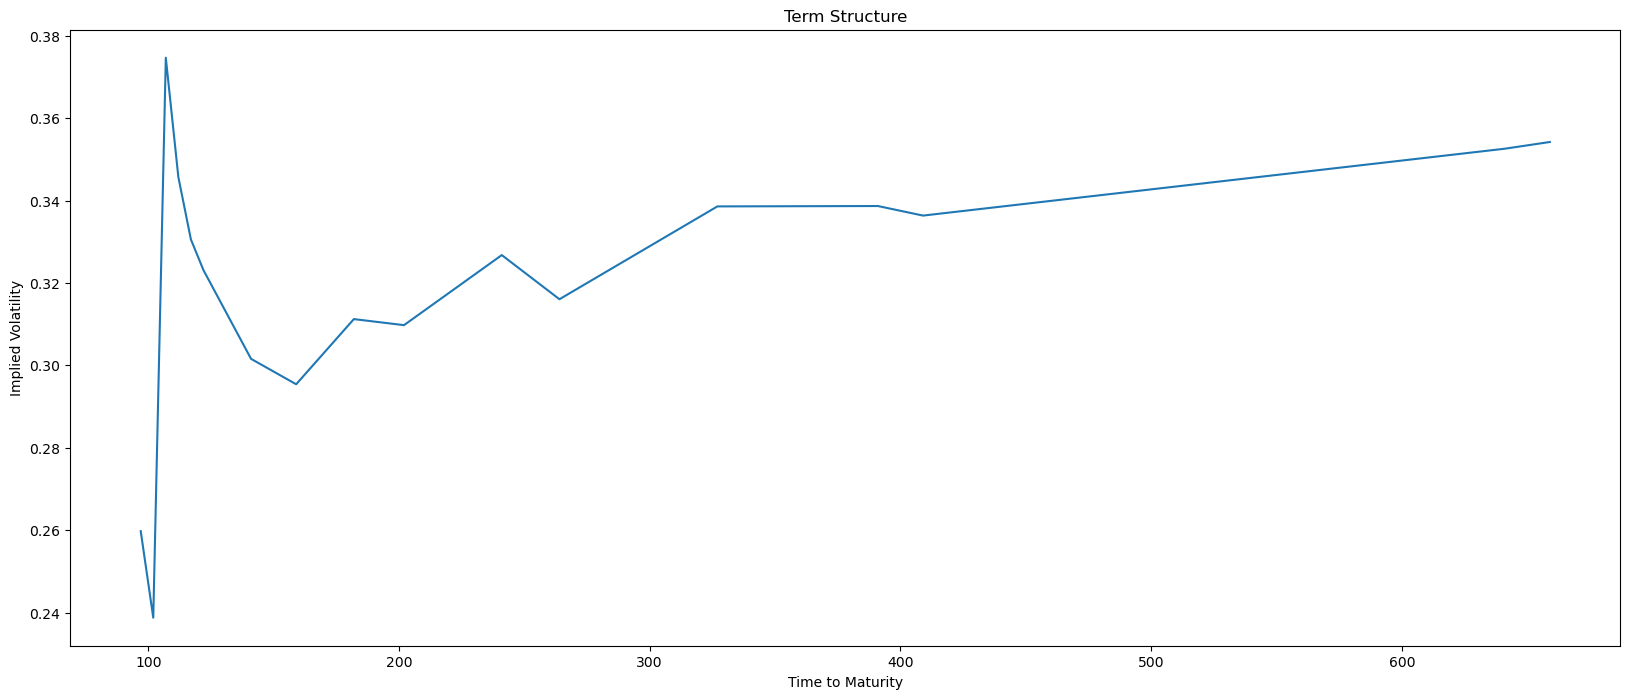

In [11]:
print('option dates: ', yf_stock.options) 
K = 175

Ivol = []
Maturity = []
for date in yf_stock.options: 
    call = yf_stock.option_chain(date)[0] 
    call = call[['strike', 'lastPrice', 'impliedVolatility']] 
    call = call[call['strike'] == K] 
    Ivol.append(call['impliedVolatility'].item()) 
    Maturity.append(len(nyse.valid_days(start_date=end_date, end_date=date))) 

fig, ax = plt.subplots(figsize=(20, 8)) 
sns.lineplot(data=pd.DataFrame({'Time to Maturity': Maturity, 'Implied Volatility': Ivol}), x = 'Time to Maturity', y = 'Implied Volatility')
ax.set(xlabel='Time to Maturity', ylabel='Implied Volatility')
ax.set_title('Term Structure')

In [72]:
option_surface = pd.DataFrame(columns=['moneyness','TTM',]) 

for date in yf_stock.options: 
    call, put = yf_stock.option_chain(date)[0], yf_stock.option_chain(date)[1] 
    call = call[call['inTheMoney'] == False] 
    put = put[put['inTheMoney'] == False] 
    option_info = call.merge(put, left_on='strike', right_on='strike', suffixes=('_call', '_put'), how='outer') 
    option_info.sort_values('strike', inplace=True) 
   # option_info = option_info[['strike','inTheMoney_call','impliedVolatility_call', 'inTheMoney_put', 'impliedVolatility_put']]
    option_info['impliedVolatility'] = option_info.apply(lambda x: implied_volatility(S, x['strike'], T, r, x['lastPrice_call']) if x['inTheMoney_call'] == False
 else implied_volatility(S, x['strike'], T, r, x['lastPrice_put'], option_type='put'), axis = 1)
    option_info['impliedVolatility_yh'] = option_info.apply(lambda x: x['impliedVolatility_call'] if x['inTheMoney_call'] == False else x['impliedVolatility_put'], axis=1)
    option_info['moneyness'] = df['Adj Close'].values[-1]/option_info['strike'] 
    option_info = option_info[['moneyness', 'impliedVolatility','impliedVolatility_yh',]]
    option_info['TTM'] = len(nyse.valid_days(start_date=end_date, end_date=date))
    option_surface = pd.concat([option_surface, option_info]) 

option_surface

,moneyness,TTM,impliedVolatility,impliedVolatility_yh
0,2.479055,97,0.516435,3.152346
1,2.313784,97,0.525407,2.527347
2,2.169173,97,0.476683,1.750001
3,2.041574,97,0.484265,1.781251
4,1.928154,97,0.359343,2.085942
...,...,...,...,...
22,0.826352,659,NaN,0.353400
23,0.788790,659,NaN,0.347693
24,0.754495,659,NaN,0.349875
25,0.723058,659,NaN,0.330939


In [26]:
option_surf1 = option_surface[['moneyness', 'TTM', 'impliedVolatility']].dropna()
option_surf1

,moneyness,TTM,impliedVolatility
0,2.479055,97,0.516435
1,2.313784,97,0.525407
2,2.169173,97,0.476683
3,2.041574,97,0.484265
4,1.928154,97,0.359343
...,...,...,...
3,1.735338,659,0.767635
4,1.577580,659,0.734785
15,1.020787,659,0.699537
16,0.991622,659,0.697719


In [30]:
option_surf2 = option_surface[['moneyness', 'TTM', 'impliedVolatility_yh']].dropna()
option_surf2

,moneyness,TTM,impliedVolatility_yh
0,2.479055,97,3.152346
1,2.313784,97,2.527347
2,2.169173,97,1.750001
3,2.041574,97,1.781251
4,1.928154,97,2.085942
...,...,...,...
22,0.826352,659,0.353400
23,0.788790,659,0.347693
24,0.754495,659,0.349875
25,0.723058,659,0.330939


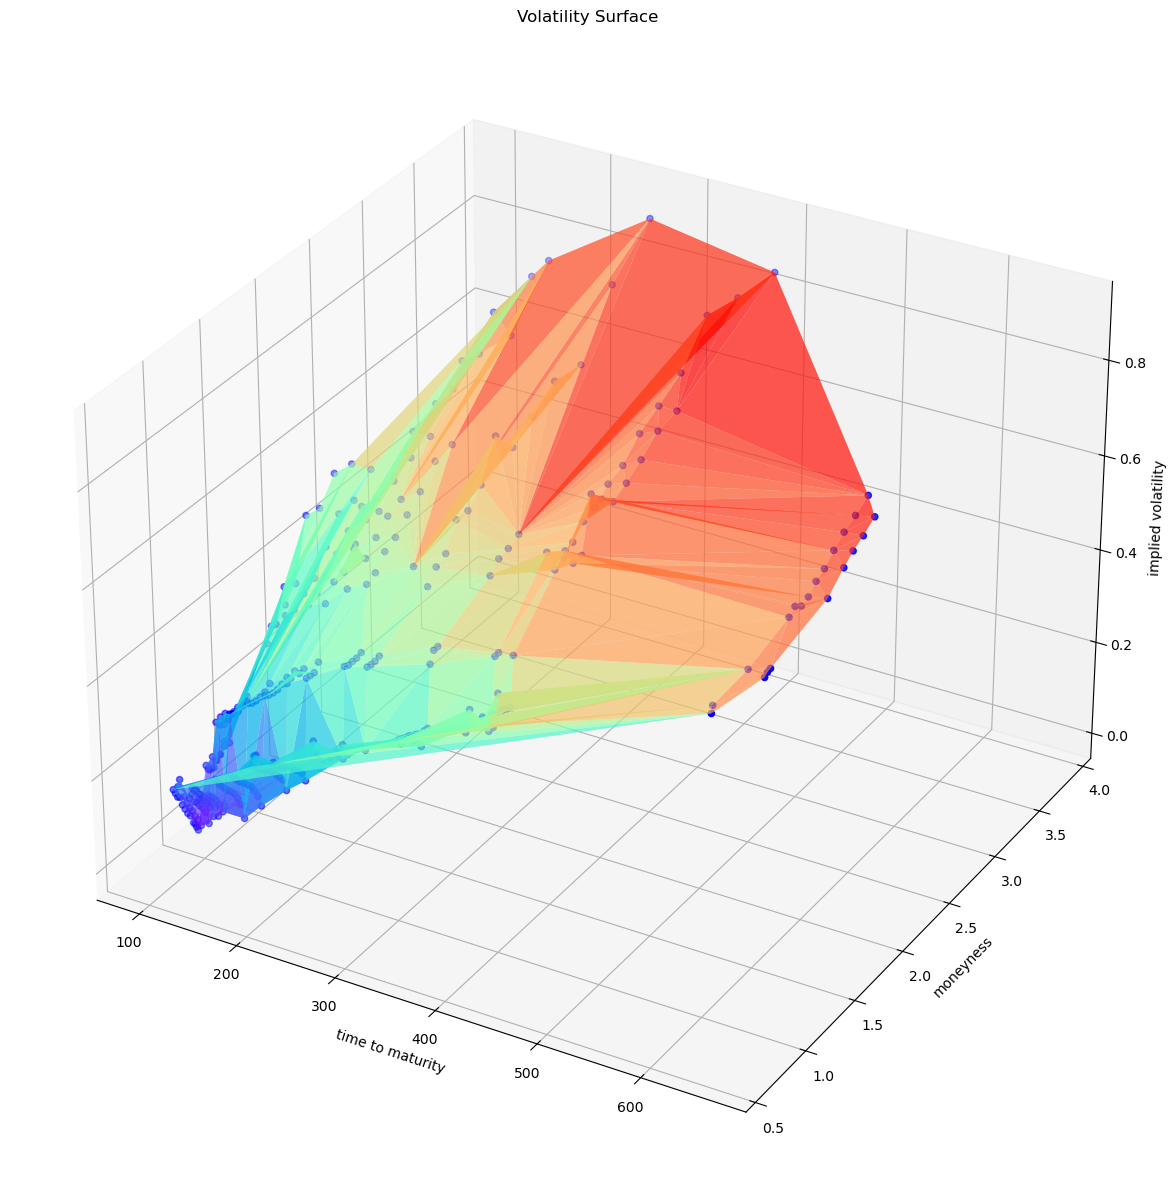

In [62]:
from matplotlib import cm
X1, Y1 = option_surf1['TTM'].to_numpy().astype(float), option_surf1['moneyness'].to_numpy() 
Z1 = option_surf1['impliedVolatility'].to_numpy()
Z2 = option_surf2['impliedVolatility_yh'].to_numpy()
fig = plt.figure(figsize=(15, 15)) 
ax = fig.add_subplot(111, projection='3d') 
ax.scatter3D(X1, Y1, Z1, c='b') 
ax.plot_trisurf(X1, Y1, Z1, cmap=cm.rainbow, alpha=0.7)

#ax.plot_surface(*(v.reshape(option_surf1.shape[0], option_surf1.shape[1]) for v in(X, Y, Z1)),
                      # cmap='Blues_r', ec='gray', lw=0.2)
#ax.plot_surface(X, Y, Z1, cmap = cm.rainbow, alpha=0.7) 
ax.set(xlabel='time to maturity', ylabel='moneyness', zlabel='implied volatility') 
ax.set_title('Volatility Surface')
plt.show()

Text(0.5, 0.92, 'Volatility Surface')

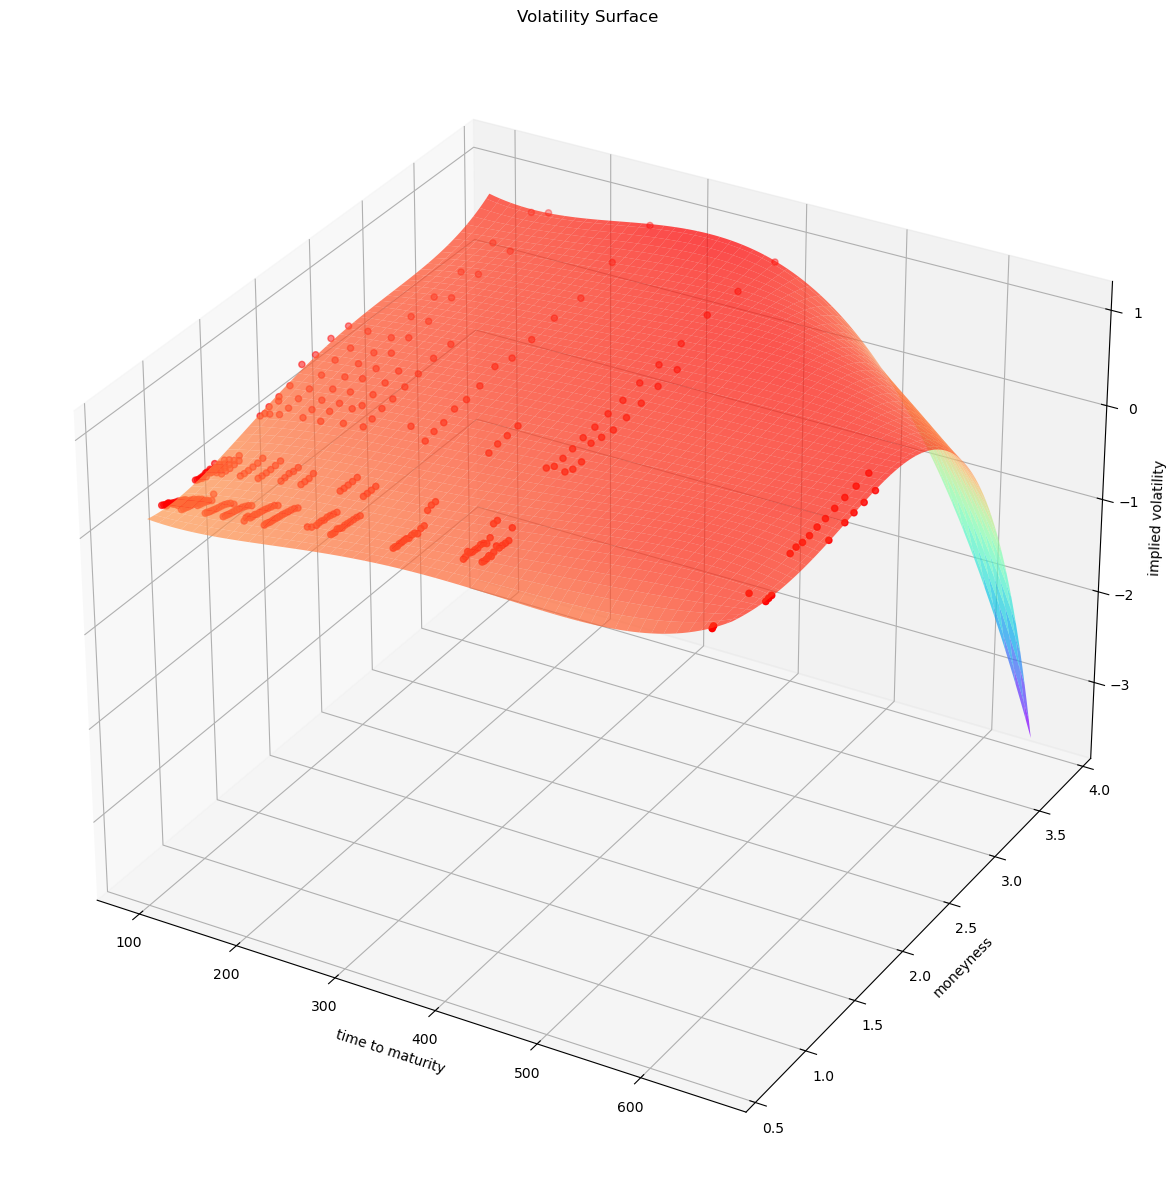

In [70]:
fig = plt.figure(figsize=(15, 15)) 
ax = fig.add_subplot(111, projection='3d') 
Xnew, Ynew = np.meshgrid(np.linspace(min(X1), max(X1),100), np.linspace(min(Y1),max(Y1), 100)) 
spline = scipy.interpolate.SmoothBivariateSpline(X1, Y1, Z1, kx=4, ky=4) 
Znew = spline.ev(Xnew, Ynew)
ax.scatter3D(X1, Y1, Z1, c='r') 
ax.plot_surface(Xnew, Ynew, Znew, cmap=cm.rainbow, alpha=0.7) 
ax.set(xlabel='time to maturity', ylabel='moneyness', zlabel='implied volatility') 
ax.set_title('Volatility Surface')

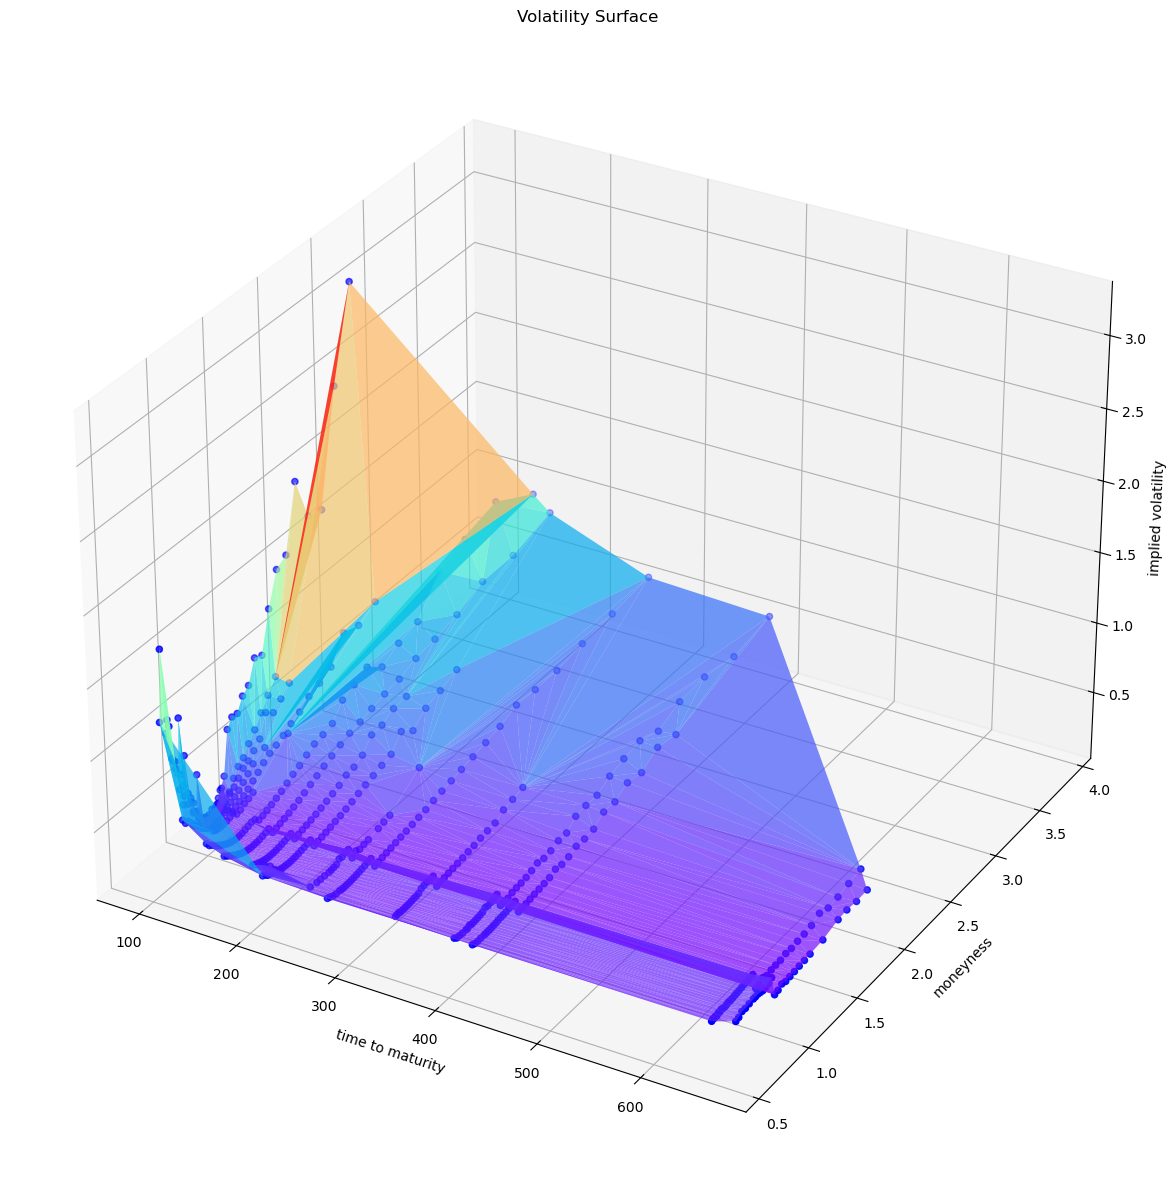

In [66]:
X2, Y2 = option_surf2['TTM'].to_numpy().astype(float), option_surf2['moneyness'].to_numpy() 
Z2 = option_surf2['impliedVolatility_yh'].to_numpy()
fig = plt.figure(figsize=(15, 15)) 
ax = fig.add_subplot(111, projection='3d') 
ax.scatter3D(X2, Y2, Z2, c='b') 
ax.plot_trisurf(X2, Y2, Z2, cmap=cm.rainbow, alpha=0.7)

#ax.plot_surface(*(v.reshape(option_surf1.shape[0], option_surf1.shape[1]) for v in(X, Y, Z1)),
                      # cmap='Blues_r', ec='gray', lw=0.2)
#ax.plot_surface(X, Y, Z1, cmap = cm.rainbow, alpha=0.7) 
ax.set(xlabel='time to maturity', ylabel='moneyness', zlabel='implied volatility') 
ax.set_title('Volatility Surface')
plt.show()

Text(0.5, 0.92, 'Volatility Surface')

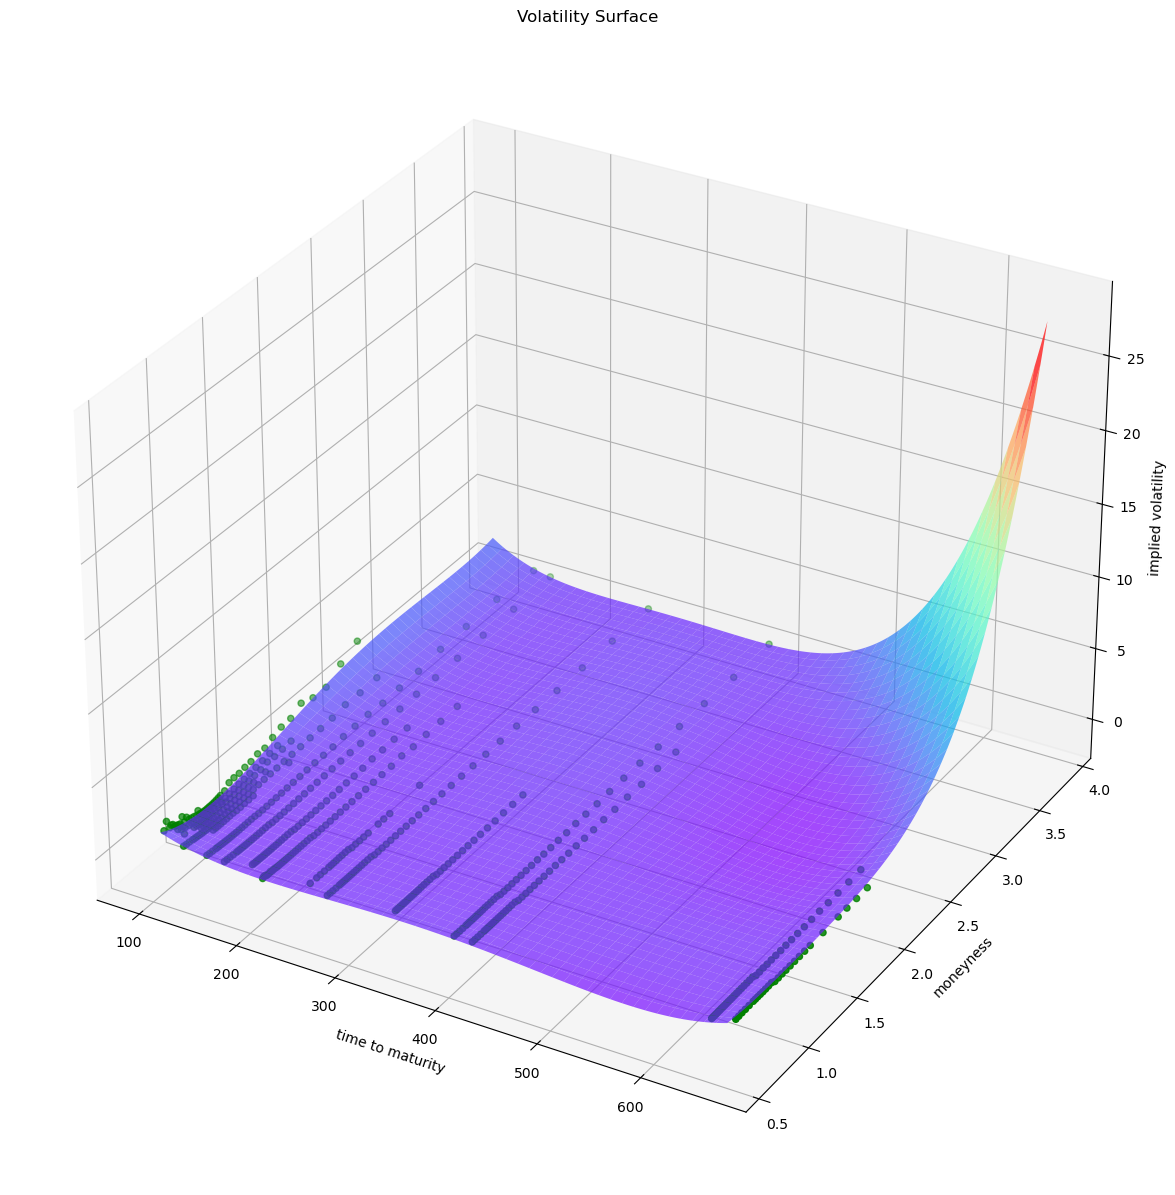

In [68]:
fig = plt.figure(figsize=(15, 15)) 
ax = fig.add_subplot(111, projection='3d') 
Xnew, Ynew = np.meshgrid(np.linspace(min(X2), max(X2),1000), np.linspace(min(Y2),max(Y2), 1000)) 
spline = scipy.interpolate.SmoothBivariateSpline(X2, Y2, Z2, kx=4, ky=4) 
Znew = spline.ev(Xnew, Ynew)
ax.scatter3D(X2, Y2, Z2, c='g') 
ax.plot_surface(Xnew, Ynew, Znew, cmap=cm.rainbow, alpha=0.7) 
ax.set(xlabel='time to maturity', ylabel='moneyness', zlabel='implied volatility') 
ax.set_title('Volatility Surface')

In [76]:
yf_stock.option_chain('2024-10-18')[0]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GOOG241018C00070000,2024-04-26 18:28:44+00:00,70.0,103.99,105.45,109.95,0.000000,0.000000,1,2,8.477055,True,REGULAR,USD
1,GOOG241018C00075000,2024-08-30 15:31:43+00:00,75.0,89.00,89.15,91.80,0.000000,0.000000,1,2,3.630860,True,REGULAR,USD
2,GOOG241018C00080000,2024-05-23 18:40:12+00:00,80.0,96.66,100.90,104.00,0.000000,0.000000,1,2,8.590825,True,REGULAR,USD
3,GOOG241018C00085000,2024-08-30 19:50:00+00:00,85.0,80.10,78.70,82.35,0.000000,0.000000,1,0,3.149416,True,REGULAR,USD
4,GOOG241018C00090000,2024-10-01 15:17:09+00:00,90.0,76.25,72.75,75.75,0.000000,0.000000,1,21,3.041018,True,REGULAR,USD
5,GOOG241018C00095000,2024-09-06 16:55:07+00:00,95.0,58.43,73.50,75.15,0.000000,0.000000,28,30,4.069341,True,REGULAR,USD
6,GOOG241018C00100000,2024-10-11 19:28:59+00:00,100.0,64.26,62.75,65.45,1.110001,1.757721,6,312,2.432621,True,REGULAR,USD
7,GOOG241018C00105000,2024-10-09 13:35:35+00:00,105.0,60.87,57.80,61.60,0.000000,0.000000,1,162,1.666017,True,REGULAR,USD
8,GOOG241018C00110000,2024-10-10 19:05:11+00:00,110.0,53.52,52.80,55.75,0.000000,0.000000,5,336,2.170903,True,REGULAR,USD
9,GOOG241018C00115000,2024-10-09 15:35:09+00:00,115.0,47.95,47.80,51.50,0.000000,0.000000,8,105,1.300785,True,REGULAR,USD
